# Event-Based Cameras for Real-Time Detection and Tracking of Indoor Ground Robots

In [1]:
import numpy as np
import cv2
from PIL import Image
from sklearn.cluster import DBSCAN

Event camera data may exist in a variety of format types.
<br>
CSV, NPY, RAW, HDF5, DAT, or even plain text (txt) are all potential storage formats for event collections.

In [2]:
# The data we will be working with is currently in csv format.
events = np.genfromtxt('1botcircle.csv', delimiter=',', dtype=int)
events

array([[     435,       75,        1,        4],
       [     421,      410,        0,       22],
       [     134,      251,        0,       33],
       ...,
       [     189,      364,        0, 19356848],
       [     419,      185,        0, 19356876],
       [     267,      299,        0, 19357099]])

In [3]:
# Examine the dimensions of the data.
events.shape

(352286, 4)

Notice that this data object has four columns and many rows.
<br>
Each row is a distinct event.

The columns are formatted as:
<br>
[x coordinate, y coordinate, polarity, timestamp]

In [4]:
# This is the first event in the dataset.
events[0]

array([435,  75,   1,   4])

This first event occurred at pixel position (435, 75) on the camera sensor,
<br>
it was a positive event (polarity of 1),
<br>
and the timestamp was 4 microseconds (from the start of recording).

# Data Acquisition

Similar to reading live data from an event-based camera, our file of events is simply an ordered (by time) list.
<br>
It is the responsibility of the developers to organize the events in a useful manner.
<br>
In order to interface with frame-based algorithms, we will use the event data to form a synthetic frame.

### What is a 'Synthetic Frame'?

A synthetic frame is simply an image frame that has not come 'naturally' from a camera.
<br>
We will use the event data to form frames which visually represent the captured scene.
<br>
These frames are grayscale, so the values for each pixel will be within 0-1 range.

### Forming an empty synthetic frame

In [5]:
# An empty synthetic frame (of size 640x480, and full of gray pixels).
empty_frame = np.zeros(shape=(640,480), dtype=np.float32)
empty_frame

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Before continuing, lets define a quick function to show images in this notebook.

In [6]:
def imshow(frame):
    synthetic_frame = frame.copy()
    # Thinking in pixel colors now...    
    # Replace all empty cells with gray pixels
    synthetic_frame[synthetic_frame == 0] = 0.5
    # Replace all negative events with black pixels
    synthetic_frame[synthetic_frame == -1] = 0
    return Image.fromarray(np.uint8(synthetic_frame*255))

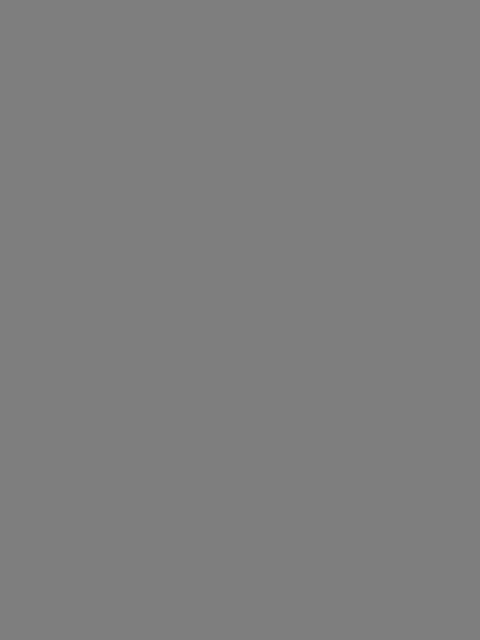

In [7]:
# View the empty frame.
imshow(empty_frame)

### Inserting the first event
Lets use events[0], the first event in the event collection, to add some content to the frame.

In [8]:
# Define a function to insert events into synthetic frame.
def insert(frame, x_coordinate, y_coordinate, p):
    
    # If the polarity of the triggering event is positive...
    if p == 1:
        
        # plot the event as 1.
        frame[x_coordinate,y_coordinate] = 1
        
    # If the polarity of the triggering event is negative... (p == 0)
    else: 
        
        # plot the event as -1.
        frame[x_coordinate,y_coordinate] = -1
    
    return frame

In [9]:
# Extract the event attributes from the first event.
x, y, polarity, timestamp = events[0]

# Insert the event into the empty frame, so that the frame is no longer empty.
frame = insert(empty_frame, x, y, polarity)

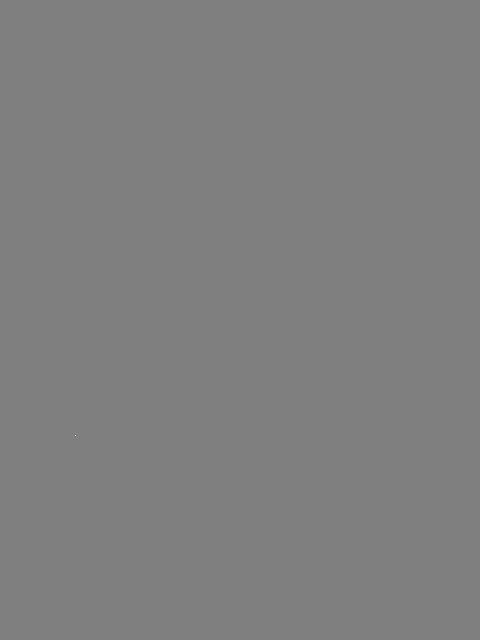

In [10]:
imshow(frame)

Can you see the event plotted in white towards the bottom left quadrant?
<br>
No? 
<br>
Let's zoom in a bit.

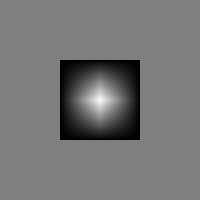

In [11]:
# Focus in on a 5x5 region around the event that was just plotted.
region = frame[x-2:x+3, y-2:y+3]

# Scale the region to 200x200 pixels, so that it can be viewed.
enhanced = cv2.resize(src=region, dsize=(200,200), interpolation=cv2.INTER_LINEAR_EXACT)

# View the region
imshow(enhanced)

### Accumulation Time

Each frame will contain events which span a consistant duration of time.
<br>
This duration is called the Accumulation Time.

In [12]:
def events_to_frames(events, acc_time):
    # This container will hold all the fully formed frames
    frames = []
    
    # The first window will start at 0 and end at <acc_time> microseconds (from the start of the recording).
    window = acc_time

    # Create an empty frame
    frame = np.zeros(shape=(640,480), dtype=np.float32)

    # Iterate through the ordered list of events
    for event in events:

        # Current event
        x,y,p,t = event

        # If the current event falls within the current window...
        if t <= window:
        
            # insert it into the current frame.
            frame = insert(frame, x, y, p)
            

        # If the current event falls outside of the current window...
        else:
            
            # advance the window,
            window += acc_time
            
            # store the current frame,
            frames.append(frame)

            # create a new empty frame,
            frame = np.zeros(shape=(640,480), dtype=np.float32)

            # and insert the current event into the current frame.
            x,y,p,t = event
            frame = insert(frame, x, y, p)
            
    return frames   

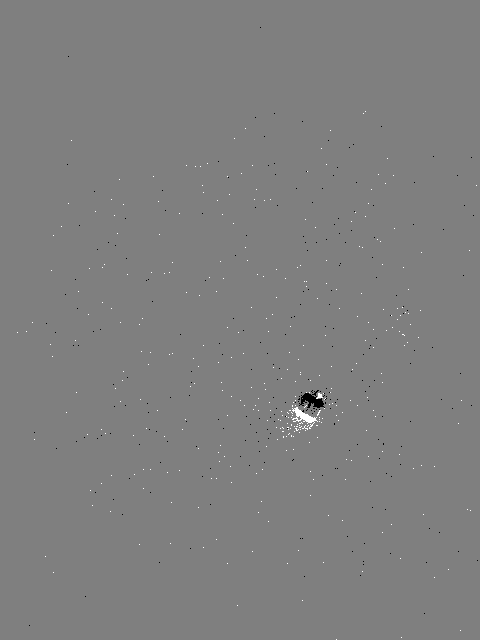

In [13]:
# Events will be accumulated into windows spanning 100,000 microseconds.
frames = events_to_frames(events, 100000)

# View a frame at random
imshow(frames[99])

A quick recap:
* An event represents a single point in time.
* An event has an x coordinate, y coordinate, polarity, and timestamp.
* Events are accumulated into frames which span a predefined window of time.

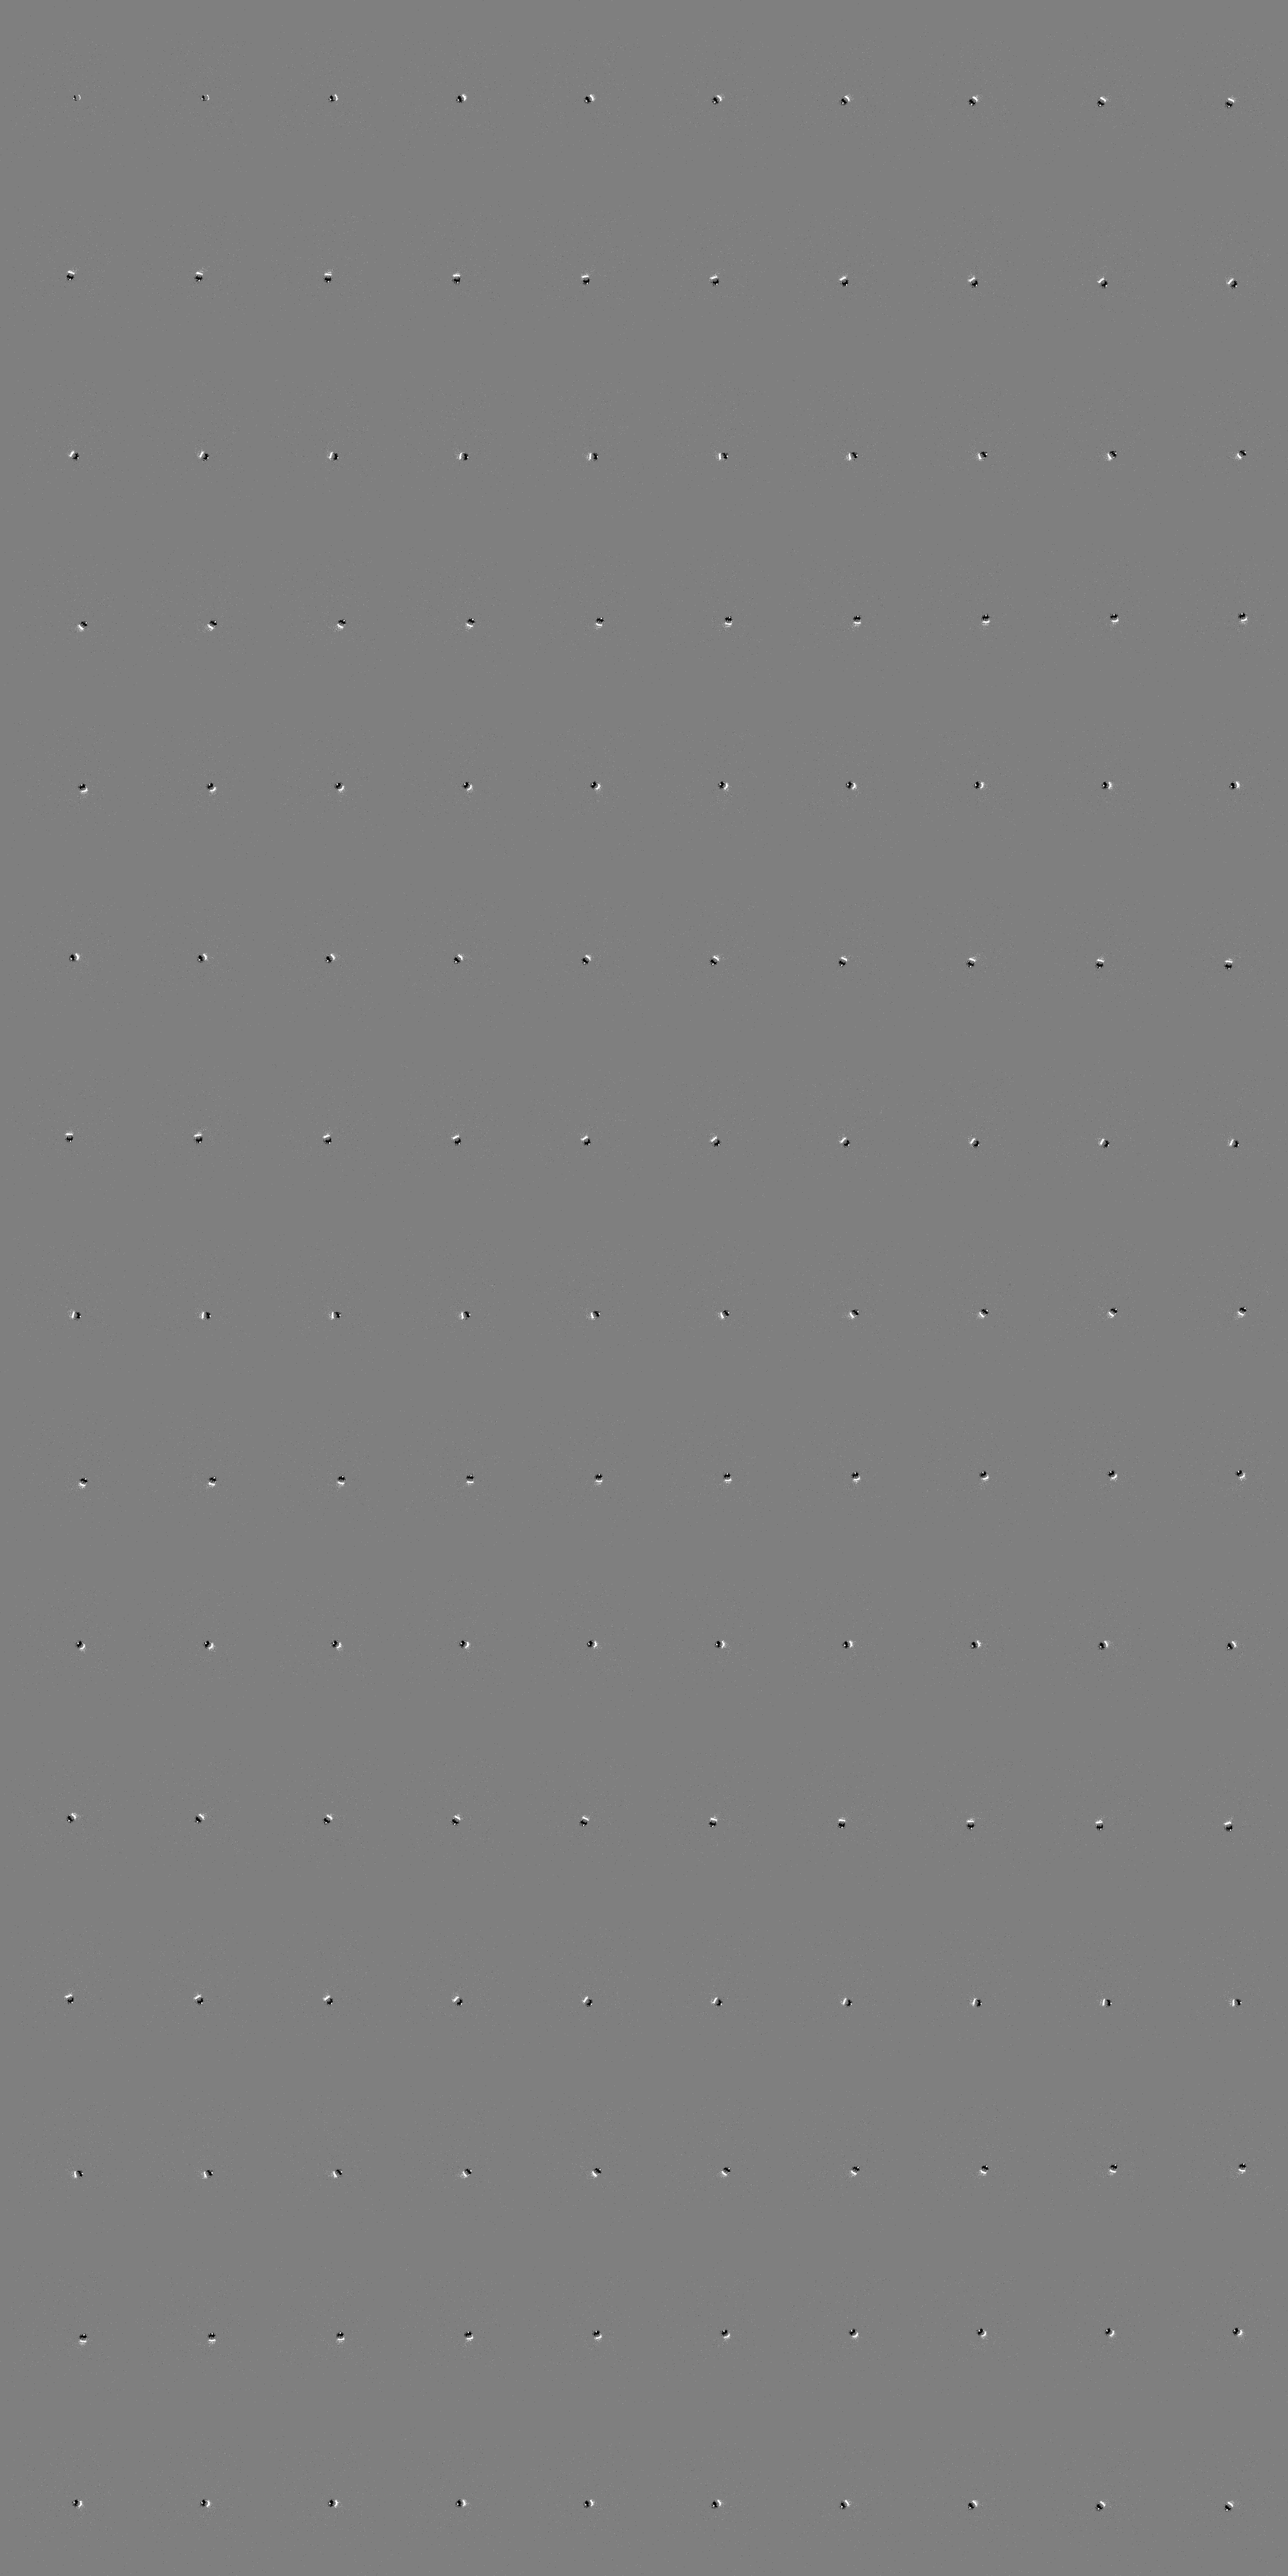

In [14]:
# Now that we have transformed our event list into frames, we can view them all at once.
# The first and last few frames have been omitted from the display below due to a lack of event activity.

# This image was formed by horizontally joining every consecutive 10 frames into rows,
# and then vertically joining the rows to complete the image.

rows = []

# for loop which will bring i from 0 to ~190 and jump ahead by 10 at each iteration
for i in range(0, len(frames), 10):
    
    # Horizontally stack 10 frames into rows
    row = np.hstack(frames[i:i+10])
    rows.append(row)

# Vertically stack the frame rows
all = np.vstack((rows[2:-3]))

imshow(all)

## Clustering for Object Detection

### Intro to DBSCAN
* Clustering: given a set of points, group them in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters).
* Density-based spatial clustering of applications with noise (DBSCAN) is one such clustering method.
* The key advantage here is that we can use DBSCAN to perform object detection in an unsupervised manner (without any training).
* This algorithm is unique among clustering algorithms for a few reasons:
  * It is not required to pre-specify the number of clusters present in the data.
  * Outliers (points which are determined to not belong to any cluster) are labeled in the data.

The data structure which DBSCAN will operate on is a 2D array, also known as a matrix.
Synthetic frames created in the a Data Acquisition stage are collections of points in matrix format, containing both 1, -1, and 0 values.

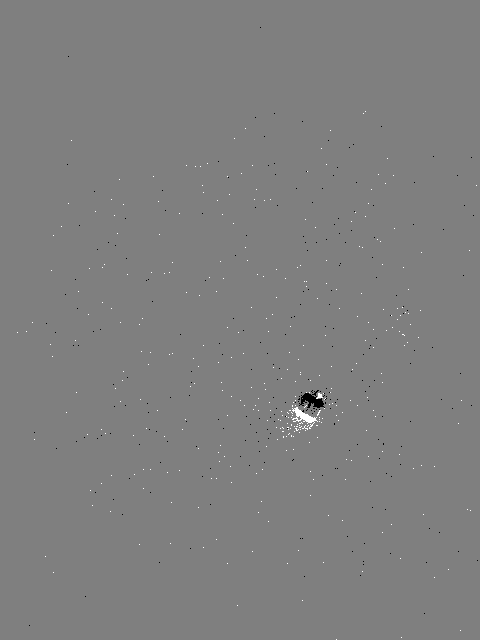

In [15]:
# Pick an image to work with
frame = frames[99]
imshow(frame)

What can be seen in this image?
* We can see that the frame is mostly full of empty space.
* We can see that there is a lot of noise present throughout the image.
* We can see that there are dense clusters of positive and negative points which represent the robot.

We will use DBSCAN to classify all of the points in the above image.
<br>
In this case, only two classifications exist:
1. Point belonging to a robot.
2. Point belonging to noise.

In [16]:
# Extract the (x,y) coordinates where events exist.
x,y = np.where(frame != 0)

# Add the columns so that x and y become a single array resembling [[x1,y1], [x2,y2], ...] 
points = np.column_stack((x,y))

# Points is now a collection of (x,y) coordinates at which an event occurred.
# For this example, we won't distinguish between positive and negative events.
points

array([[ 27, 260],
       [ 56,  68],
       [111, 365],
       ...,
       [630, 460],
       [637, 401],
       [639, 336]])

In [17]:
# Initialize the clusterer with a few key parameters.
# Epsilon: The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
# Min samples: The number of samples in a neighborhood for a point to be considered as a core point. 
clusterer = DBSCAN(eps=15, min_samples=170)

# Run the points through the clusterer
clusterer.fit(points)

DBSCAN(algorithm='auto', eps=15, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=170, n_jobs=None, p=None)

In [18]:
# By examining the clusterer labels, we can see that two classifications were found.
found_clusters = set(clusterer.labels_)
found_clusters

{-1, 0}

In [19]:
# -1 is the label reserved for noise (points which do not belong to any cluster).
# Remove the points which have been classified as noise.
found_clusters.remove(-1)

In [20]:
# Now separate the points with like labels into groups.
clusters = []

for i, label in enumerate(found_clusters):
    # Merge each (x,y) point with the label number, so that points_with_class looks like [[x1,y1,label1], [x2,y2,label2], ...]
    points_with_class = np.column_stack((points, clusterer.labels_))

    # This array contains all of indexes of (x,y) locations for a single cluster
    detected_pixel_indexes = np.where(points_with_class[:, 2] == label)

    # Now use the locations determined above to store the actual (x,y) values
    detected_pixels = points_with_class[detected_pixel_indexes]
    
    # Add all the (x,y) values for each cluster to a list
    clusters.append(detected_pixels[:, 0:2])

clusters

[array([[379, 308],
        [380, 310],
        [388, 326],
        ...,
        [436, 293],
        [437, 317],
        [442, 309]])]

In [21]:
# We might wish to know the centroid of the clusters found in the previous step
centroids = []
for cluster in clusters:
    
    # Calculate the mean of all the points in the cluster for X and Y directions.
    # This will provide the centroid of the cluster.
    meanX = int(np.mean(cluster[:,1]))
    meanY = int(np.mean(cluster[:,0]))
    
    centroids.append([meanX, meanY])

# In this case, we have a single centroid due to the singular cluster
centroids

[[307, 408]]

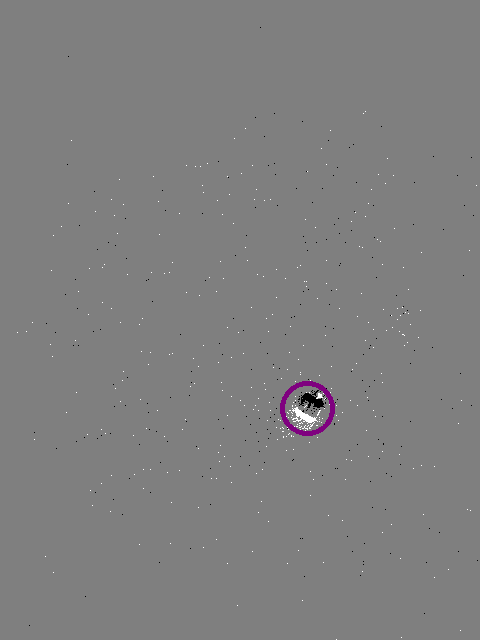

In [22]:
# In order to draw colorful circles, the image cannot be grayscale
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

# Lets mark this centroid on the frame and see if it looks correct
imshow(cv2.circle(rgb_frame, (centroids[0][0], centroids[0][1]), 25, (0,255,0), 3))

And with this step, we have made a successful detection.

## Multi-Object Detection
So far we have detected a single object on a synthetic frame.
<br>
Two cluster labels were formed by DBSCAN.
* One for the robot
* One for the noise

What if more robots are present in the scene?
<br>
Lets try four robots.

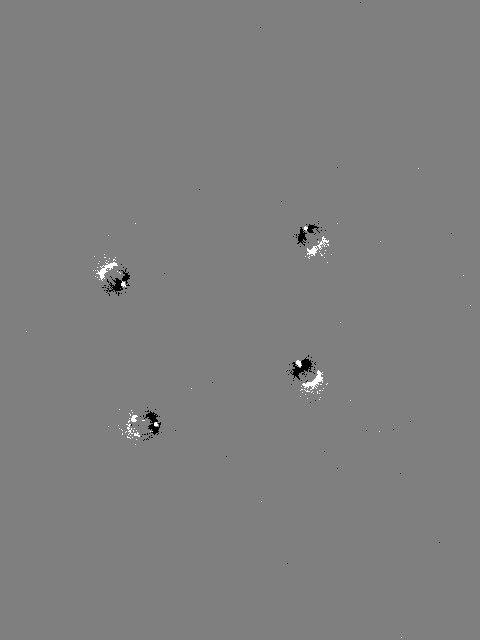

In [23]:
# Our list of events is in CSV format.
# It contains 4 robot subjects moving around in circle patterns,
events = np.genfromtxt('4botcircle.csv', delimiter=',', dtype=int)

# Convert the list of events to synthetic frames
frames = events_to_frames(events, 100000)

# Show a random frame
imshow(frames[99])

Previously, with the single robot case, we stepped through the clustering step in chunks so that the output of each step could be observed.
<br>
Now, we will condense the into a reusable functions.

In [24]:
# This function will return a list of clusters.
# A cluster is a list of (x,y) points which have been grouped together.
# So clusters, which this function, is a list of lists.
def clustering(frame, eps, minpts):
    
    # Extract the (x,y) coordinates where events exist.
    x,y = np.where(frame != 0)

    # Add the columns so that x and y become a single array resembling [[x1,y1], [x2,y2], ...] 
    points = np.column_stack((x,y))

    # Initialize the clusterer with a few key parameters.
    # Epsilon: The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
    # Min samples: The number of samples in a neighborhood for a point to be considered as a core point. 
    clusterer = DBSCAN(eps=15, min_samples=170)

    # Run the points through the clusterer
    clusterer.fit(points)
    
    # By examining the clusterer labels, we can see that two classifications were found.
    found_clusters = set(clusterer.labels_)
    
    # -1 is the label reserved for noise (points which do not belong to any cluster).
    # Remove the points which have been classified as noise.
    found_clusters.remove(-1)
    
    clusters = []

    for i, label in enumerate(found_clusters):
        # Merge each (x,y) point with the label number, so that points_with_class looks like [[x1,y1,label1], [x2,y2,label2], ...]
        points_with_class = np.column_stack((points, clusterer.labels_))

        # This array contains all of indexes of (x,y) locations for a single cluster
        detected_pixel_indexes = np.where(points_with_class[:, 2] == label)

        # Now use the locations determined above to store the actual (x,y) values
        detected_pixels = points_with_class[detected_pixel_indexes]
    
        # Add all the (x,y) values for each cluster to a list
        clusters.append(detected_pixels[:, 0:2])
        
    return clusters

In [25]:
# It's common to want to know the central point of a cluster, so this function will intake a cluster and return the (x,y) mean.
def get_centroid(cluster):

    # Calculate the mean of all the points in the cluster for X and Y directions.
    # This will provide the centroid of the cluster.
    meanX = int(np.mean(cluster[:,1]))
    meanY = int(np.mean(cluster[:,0]))
    
    return (meanX, meanY)

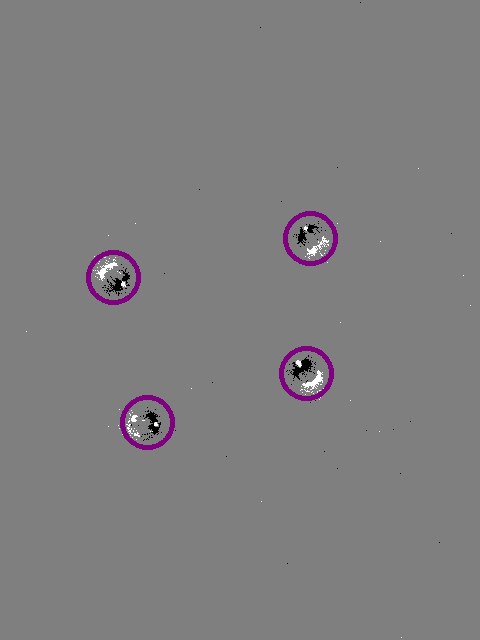

In [26]:
# In order to draw colorful circles, the image cannot be grayscale
rgb_frame = cv2.cvtColor(frames[99], cv2.COLOR_GRAY2RGB)

# Cluster on the 99th frame
clusters = clustering(frames[99], 15 , 170)

# Draw a circle around the midpoint of each cluster
for cluster in clusters:
    centroid = get_centroid(cluster)
    cv2.circle(rgb_frame, centroid, 25, (0,255,0), 3)

imshow(rgb_frame)

## Nearest Neighbors for Object Tracking

### Intro to Object Tracking
Previously, frames have been created and objects have been detected.
<br>
Object tracking is the next sequential step and will answer the fundemental question of:
<br>
"What is the path this object has moved along over time?"
<br>
as well as
<br>
"What is the unique identifier of this object?"

In order to accomplish this tracking task, we use a data structure called a K-Dimensional (k-d) Tree. 
<br>
The K-D Tree is a multidimensional search tree. More info about the structure can be found at https://en.wikipedia.org/wiki/K-d_tree.

In [27]:
# This library is not part of the Python Standard Library, so we must install it using a package manager.
!pip install kdtree

In [28]:
import kdtree

In [29]:
# A simple kdtree example

# Create a 2-dimensional k-d tree. The dimensionality refers to the objects that will be held.
# In this case, the tree will be storing 2D coordinates (x,y).
tree = kdtree.create(dimensions=2)

# The tree can be used to store tuples or lists, interchangably.
tree.add((5,10))
tree.add([2,2])

# The tree can be viewed in list format
print(list(tree.inorder()))

# Finding the node nearest to a particular point is as simple as
nearest_neighbor = tree.search_nn((1,1))
# Here, nearest_neighbor[0] holds the neighbor's values
# and nearest_neighbor[1] holds the (euclidean) distance to the neighbor

# Nodes can be removed from the tree with
tree.remove(nearest_neighbor[0].data)

# the above is functionally identical to
# tree.remove([2,2])

[<KDNode - [2, 2]>, <KDNode - (5, 10)>]


<KDNode - (5, 10)>

As shown above, the K-D Tree can be adept at storage and retrieval of coordinate values, but what about attaching information to these coordinates, such as a name value or identification number?
<br>
You may imagine performing this sort of lookup using a dictionary, but this would add many unneccesary write and read operations to our prodecures.
<br>
Instead, we can create a storable object which presents itself as a (x,y) coordinate pair, while carrying additional information 'along for the ride'. This sort of data would be called the 'payload'.
<br>
As demonstrated below, you are not limited to a single payload.

In [30]:
# This is an excessively descriptive name for a class. 
# Certainly, you can come up with something more concise for your application.
class Node_With_Payload(object):
    
    def __init__(self, x, y, payload1, payload2):
        self.coords = (x,y)
        self.payload1 = payload1
        self.payload2 = payload2
        
    # The externally facing features of the class. 
    def __getitem__(self,i):
        return self.coords[i]
    
    def __len__(self):
        return len(self.coords)
    
    # This will be shown if you attempt to print(
    def __repr__(self):
        return 'Item(x:{}, y:{}, payload1:{}, payload2:{})'.format(self.coords[0], self.coords[1], self.payload1, self.payload2)

Putting the above object to use:

In [31]:
# Init an empty kd-tree
tree = kdtree.create(dimensions=2)

# Define two nodes for the tree, each containing a payload at an (x,y) point
node1 = Node_With_Payload(5, 10, 'foo', 'New York')
node2 = Node_With_Payload(2, 2, 'bar', 'Los Angeles')

# Add the nodes to the tree
tree.add(node1)
tree.add(node2)

# Search for the nearest neighbor the point (1,1)
nearest_neighbor = tree.search_nn((1,1))

# What is the stored payload1 value of this neighbor?
nearest_neighbor[0].data.payload1

'bar'

You've seen a highly generic implementation of K-D Trees used for nearest neighbor searches, but not how to apply the concepts to Object Tracking.
<br>
All the pieces are here, so now we will use the above code to write some re-usable snippets.

In [32]:
# Since we are tracking bots, our 'node_with_payload' object will be called 'Bot'.
class Bot(object):

    # It only requires a single payload, for the identification number.
    def __init__(self, x, y, id):
        self.coords = (x, y)
        self.id = id

    def __getitem__(self, i):
        return self.coords[i]

    def __len__(self):
        return len(self.coords)

    def __repr__(self):
        return 'Item(x:{}, y:{}, id:{},)'.format(self.coords[0], self.coords[1], self.id)

We will also define a KD_Tree class which can perform a few useful tasks:

In [33]:
class KD_Tree():
    
    # Initialize a fresh tree with no ID values 
    def __init__(self):
        self.tree = kdtree.create(dimensions=2)
        self.nextID = 0

    # Print the tree as a list
    def asList(self):
        return list(self.tree.inorder())

    # Add a new bot to the tree
    def addNode(self, x, y):
        # make a bot with new data
        bot = Bot(x, y, self.nextID)

        # add to tree
        self.tree.add(bot)

        # increment nextID counter
        self.nextID +=1

    # Update an existing bot with new information
    def updateNode(self, x, y, neighbor):
        
        # Save the neighbor's id
        id = neighbor[0].data.id

        # Remove old match from the tree
        self.tree = self.tree.remove(neighbor[0].data)

        # Make a bot with new coordinates and old ID
        bot = Bot(x, y, id)

        # Insert bot to tree
        self.tree.add(bot)
    
    # Search the tree for a nearest neighbor
    def NN(self, x, y):
        return self.tree.search_nn((x,y))

Now you have written an object tracker!
<br>
Time to put it to use.

In [34]:
# A quick function to draw information on a frame given a tree in list form
def drawAnnotations(img, tree_list):
    for bot in tree_list:
        # x,y coordinates of bot
        b_x = int(bot.data.coords[0])
        b_y = int(bot.data.coords[1])

        # id of bot
        b_id = bot.data.id

        # string formatting for label
        coords = '(' + str(b_x) + ' , ' + str(b_y) + ')'
        
        # place our strings on the image at some locations
        cv2.putText(img, str(b_id), (b_x - 10, b_y - 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
        cv2.putText(img, coords, (b_x - 10, b_y - 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

        # draw a nice box around each bot's label
        cv2.rectangle(img, 
            (b_x - 15, b_y - 40), 
            (b_x + 90, b_y - 90),
            2)
        
        # draw a circle at the bot's centroid
        cv2.circle(img, (b_x, b_y), 4, (0,0,255), -1)
    return img

In [35]:
def tracker(frames):
    
    drawn_frames = []
    
    # Init a tree for tracking
    tree = KD_Tree()

    # The maximum euclidian distance at which a found neighbor in future frames can be considered to be the same bot at a new position.
    bot_width = 100

    # Stepping through each frame...
    for frame in frames:

        # Detect all the clusters in the frame (which do not belong to noise)
        clusters = clustering(frame, 15 , 170)

        for cluster in clusters:

            # Find the center point of each detected cluster
            centroid = get_centroid(cluster)

            bot_x = centroid[0]
            bot_y = centroid[1]

            # First bot detected case
            if not tree.tree: # will be true if tree is empty
                tree.addNode(bot_x, bot_y)

            else:
                # Find the distance between the current detection and the nearest neighbor
                neighbor = tree.NN(bot_x, bot_y)
                distanceFromNeighbor = neighbor[1]

                # If the distance is too great, this is a new bot
                if distanceFromNeighbor > bot_width:
                    tree.addNode(bot_x, bot_y)

                # Otherwise, a previous bot was at this location and the info on that older bot should be updated
                else:
                    tree.updateNode(bot_x, bot_y, neighbor)
        
        drawn_frames.append(drawAnnotations(frame, tree.asList()))

    return drawn_frames

In [36]:
# Run the tracker
drawn_frames = tracker(frames)

In [37]:
# This snippet is *only* needed to show videos in a notebook environment. 
# In a normal Python script, you would cv2.imShow(frame) within a main loop which accesses each frame as it becomes available. 
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML
import numpy as np

def plot_sequence_images(image_array):
    ''' Display images sequence as an animation in jupyter notebook
    
    Args:
        image_array(numpy.ndarray): image_array.shape equal to (num_images, height, width, num_channels)
    '''
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[:2]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=33, repeat_delay=1, repeat=True)
    display(HTML(anim.to_html5_video()))


plot_sequence_images(drawn_frames)

<Figure size 480x640 with 0 Axes>